In [184]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
%env "WANDB_NOTEBOOK_NAME" "Thesis"

env: "WANDB_NOTEBOOK_NAME"="Thesis"


In [186]:
from core.datahandler import DataHandler
from metrics.rsa import RepresentationalSimilarityAnalysis
from core.trainer import Trainer
from core.tester import Tester
from metrics.lossfunctions import TimeSeriesSimilarityLoss
import gzip
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pathlib import Path
from torchvision import transforms
import torch
from utils.constants import TCNAE_EEG_DECODER_MODEL, RESNET_IMAGE_CLASSIFICATION_MODEL

# Train and test models

In [187]:
# Use models specifiec in constants
from utils.constants import TCNAE_EEG_DECODER_MODEL, RESNET_LATENT_EEG_MODEL, RESNET_IMAGE_CLASSIFICATION_MODEL 

# Or set the name of the model
model_name = "3_channels/ResNet_mse4_13_05_2024__14_16"

model_path_prefix = "../trained_models/"
model_path = model_path_prefix + model_name + ".pth"

In [ ]:
trainer = Trainer()
trainer.train(show_progress_plots=False, use_wandb=False, sweep=False)

In [ ]:
tester = Tester()
result = tester.test_model(model_name=TCNAE_EEG_DECODER_MODEL)

(rmse, wasserstein, tss, acs) = result

print(f'Achieved RMSE: {rmse:.8f}')
print(f'Achieved Wasserstein Distance: {wasserstein:.8f}')
print(f'Achieved Algonauts Challenge Score: {acs:.8f}')
#print(f'Achieved Time Series Similarity: {tss:.8f}')

# Find smallest and largest image dimensions

In [189]:
import pickle as p

# Load image paths
image_file_path = "../data/datasets/one_person/IMAGES.p"
with open(image_file_path, 'rb') as f:
            image_data = p.load(f)
            # Reduce all classes to 12 samples each
            image_data = image_data[:22248]

smallest = (1000000000, 1, 1)
largest = (0, 1, 1)

for i, image_path in enumerate(image_data):
    image_path = (f"..\{image_path}").replace("\\", "/")
    image = plt.imread(image_path)
    if image.shape[0] * image.shape[1] < smallest[0] * smallest[1]:
        smallest = image.shape
    if image.shape[0] * image.shape[1] > largest[0] * largest[1]:
        largest = image.shape

print("Smallest image size (HxWxC):", smallest)
print("Largest image size (HxWxC):", largest)

Smallest image size (HxWxC): (480, 480, 3)
Largest image size (HxWxC): (6712, 6712, 3)


# Image transformation preview

In [190]:
# Read image an perform transformation

img_path = "../stimuli/cat/cat_03s.jpg"
img = Image.open(img_path).convert('RGB')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


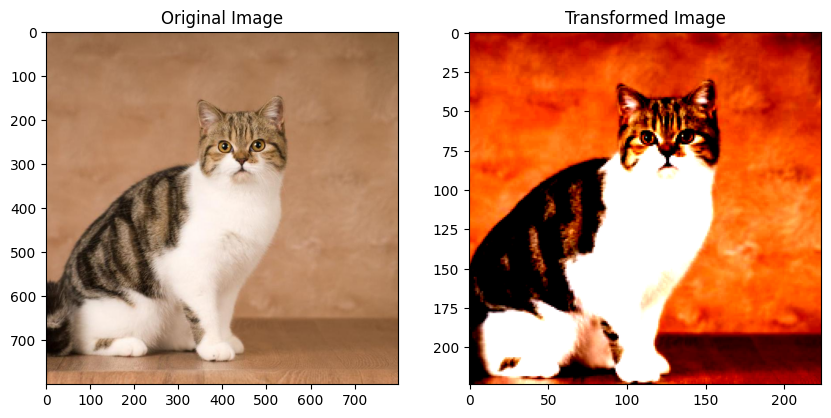

In [191]:
# Transforms
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Show image before and after transformation with subplot
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[1].imshow(transform(img).permute(1, 2, 0))
ax[1].set_title('Transformed Image')
plt.show()

# EEG Electrode/Channel Visualizations

Approximating Fpz location by mirroring Oz along the X and Y axes.


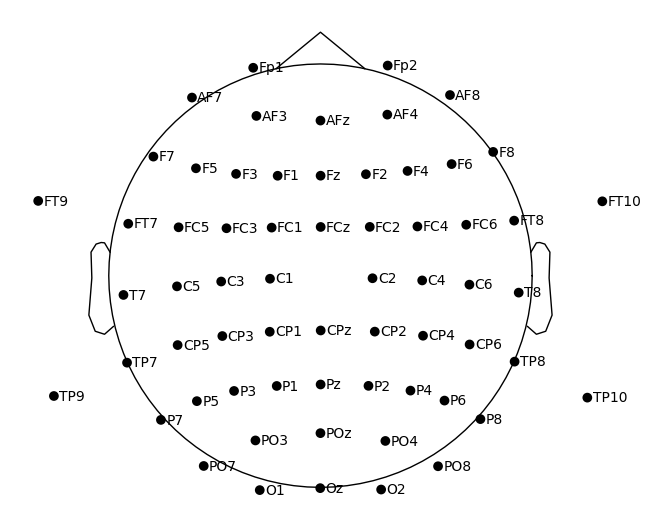

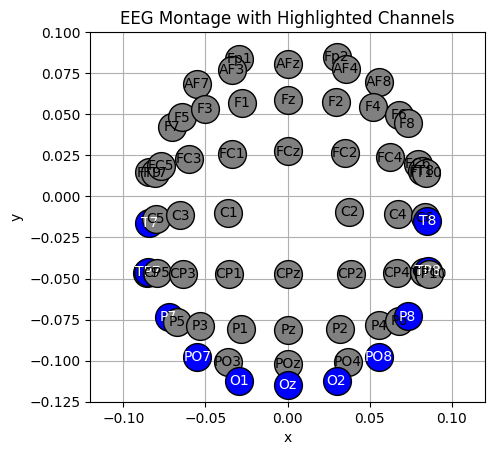

In [194]:
import mne
import matplotlib.pyplot as plt
from utils.constants import CH_NAMES

# Define the channels to highlight
highlight_channels = ["O1", "Oz", "O2", "T7", "T8", "TP7", "TP8", "P7", "P8", "PO7", "PO8"]  # Replace with your specific channels

# Create a standard montage for the 10-20 system
montage = mne.channels.make_standard_montage('standard_1020')

# Filter the montage to only include channels in ch_names
ch_pos = {ch: pos for ch, pos in montage.get_positions()['ch_pos'].items() if ch in CH_NAMES}
montage_subset = mne.channels.make_dig_montage(ch_pos=ch_pos, coord_frame='head')

# Create an info object
info = mne.create_info(ch_names=CH_NAMES, sfreq=1000, ch_types='eeg')
info.set_montage(montage_subset)

# Plot the montage
fig = mne.viz.plot_montage(montage_subset, show_names=True, sphere='eeglab')
plt.show()

# Highlight specific channels by adding circles around them
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_title('EEG Montage with Highlighted Channels')
for ch_name, (x, y, z) in montage_subset.get_positions()['ch_pos'].items():
    ax.plot(x, y, 'o', markersize=20, markeredgecolor='black', markerfacecolor='blue' if ch_name in highlight_channels else 'gray', markeredgewidth=1)
    ax.text(x, y, ch_name, color='white' if ch_name in highlight_channels else 'black', fontsize=10, ha='center', va='center')

ax.set_xlim(-0.12, 0.12)
ax.set_ylim(-0.125, 0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.


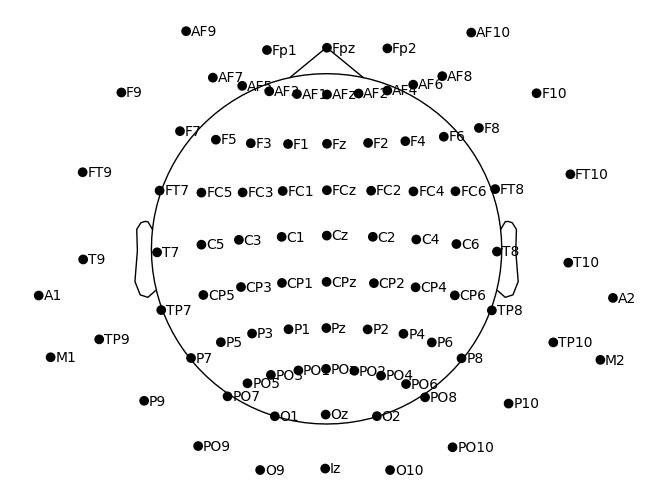

In [195]:
import mne
import matplotlib.pyplot as plt

# Create a standard montage for the 10-20 system
montage = mne.channels.make_standard_montage('standard_1020')

# Plot the montage
fig = mne.viz.plot_montage(montage, show_names=True, sphere="eeglab")

plt.show()


# Visualize feature maps

In [196]:
%%capture
# Load ResNet model
resnet_model = torch.load(f'..\\trained_models\\{RESNET_IMAGE_CLASSIFICATION_MODEL}.pth', map_location=torch.device('cpu'))
resnet_model.eval()

In [197]:
# Load image
img_path = "../stimuli/cat/cat_03s.jpg"
img = Image.open(img_path).convert('RGB')

# Set img to tensor
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img_tensor = transform(img).unsqueeze(0)

In [198]:
# Function to hook the layers
feature_maps = []

# Clear the feature_maps list at the beginning of the cell to reset it
feature_maps.clear()

def get_features_hook(module, input, output):
    feature_maps.append(output)

# Loop through and attach hook to the convolutional blocks
for layer in resnet_model.encoder.conv_layers.children():
    if isinstance(layer, torch.nn.ReLU):
        # Ensure you detach previously attached hooks if re-running this notebook cell
        layer._forward_hooks.clear()  # This line clears any existing hooks in the layer
        hook = layer.register_forward_hook(get_features_hook)
    if isinstance(layer, torch.nn.Sequential):
        layer._forward_hooks.clear()
        hook = layer.register_forward_hook(get_features_hook)

# Process image and transform
transformed_img = torch.unsqueeze(transform(img), 0)
output = resnet_model(transformed_img)

# Remove the hook
hook.remove()

# Remove hooks after you're done to prevent memory leaks
for layer in resnet_model.encoder.conv_layers.children():
    if isinstance(layer, torch.nn.Sequential):
        layer._forward_hooks.clear()

In [199]:
for i in range(len(feature_maps)):
    if i == 0:
        print(f"Initial conv: {feature_maps[i].shape}")
    else:
        print(f"Block {i}: {feature_maps[i].shape}")

Initial conv: torch.Size([1, 64, 112, 112])
Block 1: torch.Size([1, 64, 56, 56])
Block 2: torch.Size([1, 128, 28, 28])
Block 3: torch.Size([1, 256, 14, 14])
Block 4: torch.Size([1, 512, 7, 7])


C:\Users\simon\AppData\Local\Temp\ipykernel_20040\4240835758.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


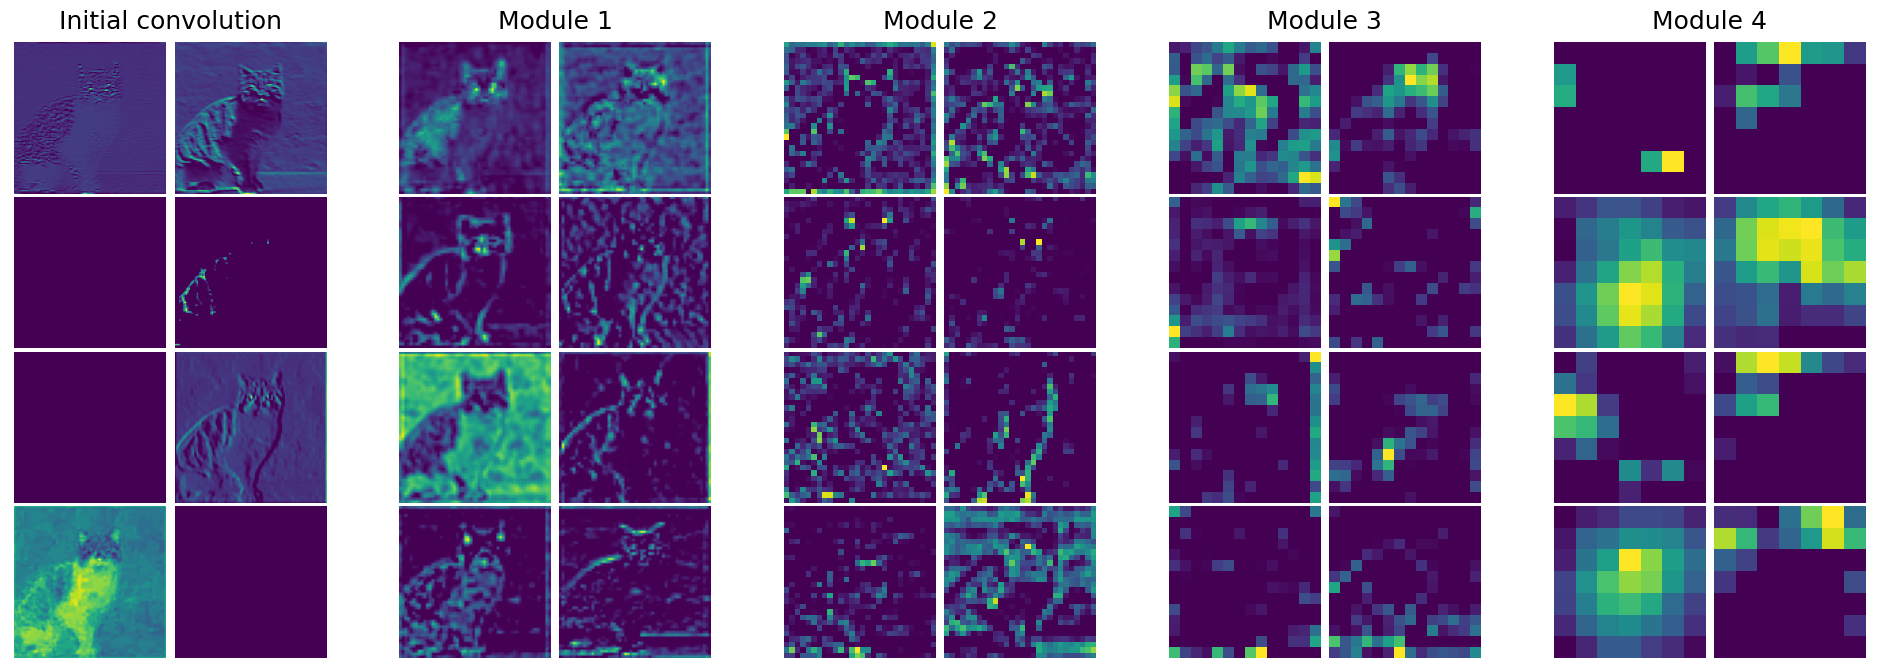

In [200]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a grid for 5 sets of 4x2 subplots
fig = plt.figure(figsize=(24, 8))
outer_grid = gridspec.GridSpec(1, 5, wspace=0.2, hspace=0)

titles = ["Initial convolution", "Module 1", "Module 2", "Module 3", "Module 4"]

# Loop over each of the 5 subplots
for outer_idx in range(5):
    # Create a grid for the current 4x2 subplots
    inner_grid = gridspec.GridSpecFromSubplotSpec(4, 2, subplot_spec=outer_grid[outer_idx], wspace=0, hspace=0.02)
    
    feature_map = feature_maps[outer_idx][0].cpu().detach().numpy()

    # Set custom range if outer_idx is 0
    if outer_idx == 0:
        n_iter = 50
        iter_range = range(n_iter, n_iter+8, 1)
    else:
        iter_range = range(8)
    
    # Plot 8 feature maps in the 4x2 grid
    for i in range(8):
        ax = plt.Subplot(fig, inner_grid[i // 2, i % 2])
        ax.imshow(feature_map[i], cmap='viridis')
        ax.axis('off')
        fig.add_subplot(ax)
    
    # Add title for each 2x4 grid on the topmost subplot
    top_ax = fig.add_subplot(inner_grid[0, :])
    top_ax.set_title(titles[outer_idx], pad=10, fontsize=18)
    top_ax.axis('off')  # Hide the topmost subplot

plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.show()


# EEG transformation visualization

In [201]:
from utils.constants import RAW_EEG_FILE, CH_NAMES

eeg_file_path = f"../data/datasets/one_person/{RAW_EEG_FILE}"

# Load EEG data
with gzip.GzipFile(eeg_file_path, "r") as f:
    eeg_data = torch.from_numpy(np.load(file=f))[:22248, :, :].float()

In [202]:
from utils.config_loader import ConfigLoader

config = ConfigLoader()
dataset_name = config.current_dataset
dataset_config = getattr(config.datasets, dataset_name)
frequency_scalar = config.transformations.eeg.new_freq / 1000
t_min = int(dataset_config.tmin * frequency_scalar)
t_max = int(dataset_config.tmax * frequency_scalar)

In [203]:
# Visualization storage
figures = []

In [204]:
# Remove unwanted channels from EEG data
channels = config.used_channels
if channels != 'All':
    channel_indices = []
    for channel in channels:
        if channel in CH_NAMES:
            idx = CH_NAMES.index(channel)
            channel_indices.append(idx)
    data = eeg_data[:, channel_indices] 

In [205]:
data_shape = data.shape[2]

In [206]:
figures.append((data, "Raw epoched EEG data", data_shape))

In [207]:
from scipy import signal

# Filter data, lowpass and highpass
fs = 1000
low_pass = config.transformations.eeg.low_pass
high_pass = config.transformations.eeg.high_pass
order = 4
nyquist = 0.5 * fs
low_pass_norm = low_pass / nyquist
high_pass_norm = high_pass / nyquist
sos = signal.butter(order, [high_pass_norm, low_pass_norm], btype='bandpass', output='sos')
filtered_data = np.copy(signal.sosfiltfilt(sos, data))

In [208]:
filtered_shape = filtered_data.shape[2]

In [209]:
figures.append((filtered_data, "Filtering/smoothing", filtered_shape))

In [210]:
import torchaudio.transforms as TA

# Downsample data
filtered_data = torch.tensor(filtered_data, dtype=torch.float)
transform = TA.Resample(
    orig_freq=1000,
    new_freq=config.transformations.eeg.new_freq
)
resampled_data = transform(filtered_data)

In [211]:
resampled_shape = resampled_data.shape[2]

In [212]:
figures.append((resampled_data, "Downsampling", resampled_shape))

In [213]:
# Baseline correction (and cut to specified interval)
baseline_correction = torch.mean(resampled_data[:, :, 0:t_min], axis=2).unsqueeze(-1)
baseline_data = (resampled_data - baseline_correction)[:, :, t_min:t_max]

In [214]:
baseline_shape = baseline_data.shape[2]

In [215]:
figures.append((baseline_data, "Baseline correction and interval selection", baseline_shape))

In [216]:
from sklearn.preprocessing import RobustScaler

robust_data = torch.tensor(np.copy(baseline_data))

# Channel wise Robust Scalar
for channel in range(len(channels)):
    robust_data[:, channel, :] = torch.from_numpy(RobustScaler().fit_transform(baseline_data[:, channel, :]))

In [217]:
robust_shape = robust_data.shape[2]

In [218]:
figures.append((robust_data, "Robust scaling", robust_shape))

In [219]:
# Random number between 0 and 22248
random.seed(42)
n = random.randint(0, 22248)

def plot_transformations(figures, n_sample=n):
    fig, axs = plt.subplots(len(figures), 1, figsize=(12, 2.5*len(figures)))
    if len(figures) == 1:
        axs = [axs]

    for i, (ax, (data, title, shape)) in enumerate(zip(axs, figures)):
        ax.plot(data[n_sample, 1, :])
        ax.set_title(f'Step {i+1}: {title} - Timepoints: {shape}')
        ax.set_ylabel('Amplitude')
    plt.tight_layout()

    # Set ylabel with spacing
    axs[2].yaxis.set_label_coords(-0.0425, 0.5)
    axs[-1].set_xlabel('Time')
    plt.show()

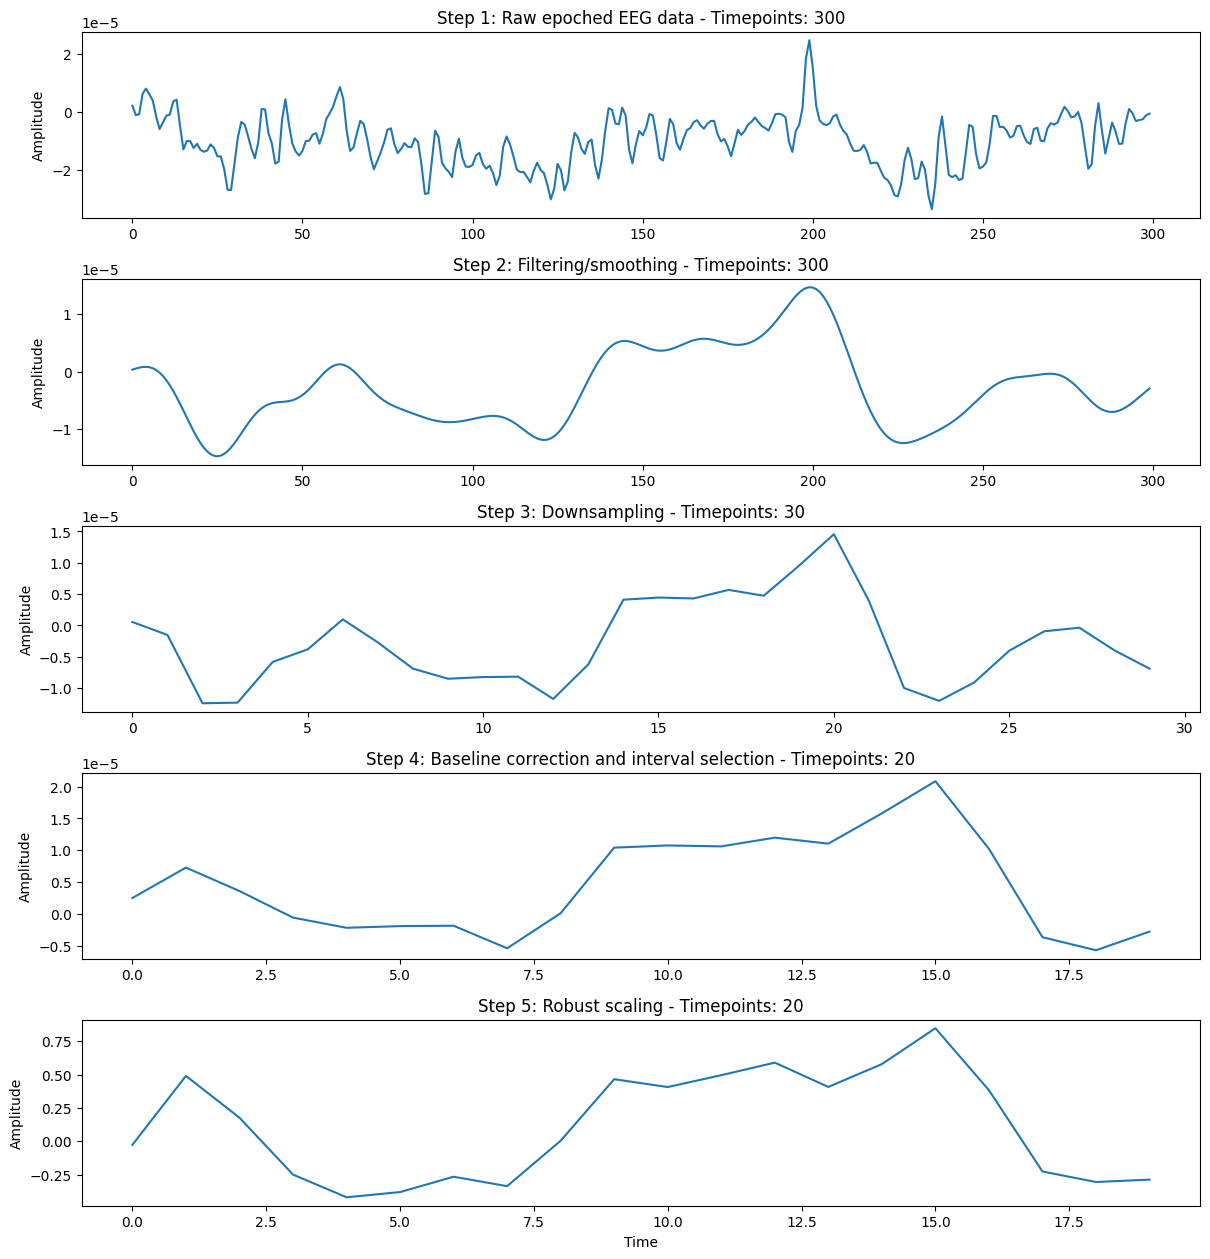

In [220]:
plot_transformations(figures, n_sample=n)

# Plot loss from CSV

In [221]:
# Load CSV file into a pandas DataFrame
import pandas as pd
df = pd.read_csv('../trained_models/MSELoss_models_results.csv')
df_mpldropout = pd.read_csv('../trained_models/baseline_vs_dropout.csv')
df_simpleresnet = pd.read_csv('../trained_models/complex_vs_simple_ResNetLatentEEG.csv')

In [222]:
# Only take columns with key 'Step' and columns with key that does NOT contain 'MIN', 'MAX'
df = df[[col for col in df.columns if 'Step' in col or ('MIN' not in col and 'MAX' not in col)]]
df_mpldropout = df_mpldropout[[col for col in df_mpldropout.columns if 'Step' in col or ('MIN' not in col and 'MAX' not in col)]]
df_simpleresnet = df_simpleresnet[[col for col in df_simpleresnet.columns if 'Step' in col or ('MIN' not in col and 'MAX' not in col)]]

In [223]:
# Index on "Step"
df.set_index('Step', inplace=True)
df_mpldropout.set_index('Step', inplace=True)
df_simpleresnet.set_index('Step', inplace=True)

# Rename "Step" to "Epoch"
df.index.names = ['Epoch']
df_mpldropout.index.names = ['Epoch']
df_simpleresnet.index.names = ['Epoch']

In [224]:
# Create three dataframes from df each with step as index, split by model names 'BaselineEEGReconstruction', 'ResNet', and 'ResNetLatentEEG'
df_baseline = df[[col for col in df.columns if 'BaselineEEGReconstruction' in col]]
df_resnet = df[[col for col in df.columns if 'ResNet_' in col]]
df_resnet_latent = df[[col for col in df.columns if 'ResNetLatentEEG' in col]]

In [225]:
df_combined = [df_baseline, df_resnet, df_resnet_latent]

In [226]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.cm as cm

def plot_dataframe(plot_dataframe, epochs=1000, name=None, legend_loc='best', y_title=True, x_title=True, multicolor=True, legends=None):
    plot_dataframe = plot_dataframe[:epochs]

    # Set height and width of plot
    plt.figure(figsize=(12, 4))

    # matplotlib colors
    colors = cm.tab10.colors

    # Initialize a counter for colors
    color_idx = 0

    # Plot train loss
    for col in plot_dataframe.columns:
        if 'train_loss' in col:
            if multicolor:
                plt.plot(plot_dataframe.index, plot_dataframe[col], linestyle='-', color=colors[color_idx])
                color_idx += 1
            else:
                if "15_05_2024__10_45" in col or "15_05_2024__10_42" in col or "15_05_2024__10_40" in col:
                    plt.plot(plot_dataframe.index, plot_dataframe[col], linestyle='-', color='green')
                elif "13_05_2024__12_24" in col or "13_05_2024__12_30" in col or "13_05_2024__12_37" in col:
                    plt.plot(plot_dataframe.index, plot_dataframe[col], linestyle='-', color='purple')
            
    # Reset the color counter for val_loss
    color_idx = 0

    # Plot val loss
    for col in plot_dataframe.columns:
        if 'val_loss' in col:
            if multicolor:
                plt.plot(plot_dataframe.index, plot_dataframe[col], linestyle=':', color=colors[color_idx])
                color_idx += 1
            else:
                if "15_05_2024__10_45" in col or "15_05_2024__10_42" in col or "15_05_2024__10_40" in col:
                    plt.plot(plot_dataframe.index, plot_dataframe[col], linestyle=':', color='green')
                elif "13_05_2024__12_24" in col or "13_05_2024__12_30" in col or "13_05_2024__12_37" in col:
                    plt.plot(plot_dataframe.index, plot_dataframe[col], linestyle=':', color='purple')

    if legends == None:
        # Create custom legend handles
        train_loss_line = mlines.Line2D([], [], color='black', linestyle='-', label='Training Loss')
        val_loss_line = mlines.Line2D([], [], color='black', linestyle=':', label='Validation Loss')

        # Add the custom legend to the plot
        plt.legend(handles=[train_loss_line, val_loss_line], loc=legend_loc)
    else:
        # Set custom legend with names of legends variable and same colors used to plot
        plt.legend(legends, loc=legend_loc)

    # Adjust title and label sizes
    #plt.title(f'{name} - Training and Validation Loss')
    if y_title:
        plt.ylabel('Loss')
    if x_title:
        plt.xlabel('Epoch')

    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

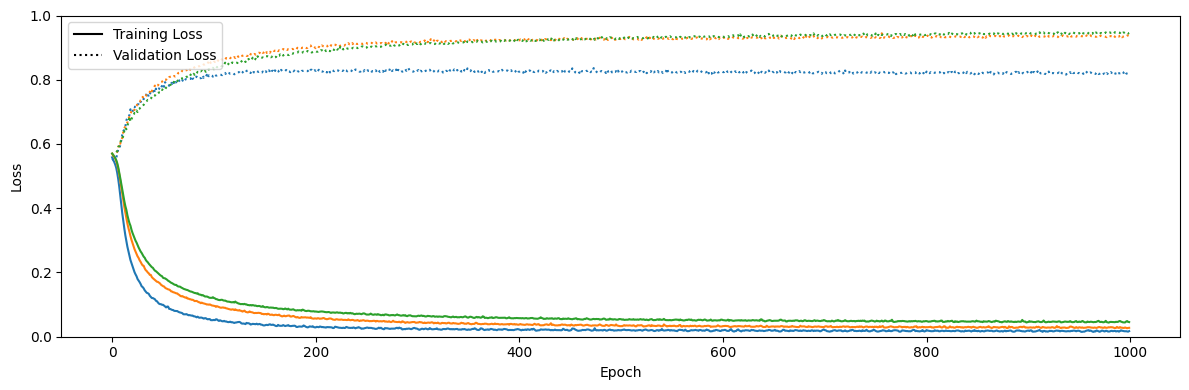

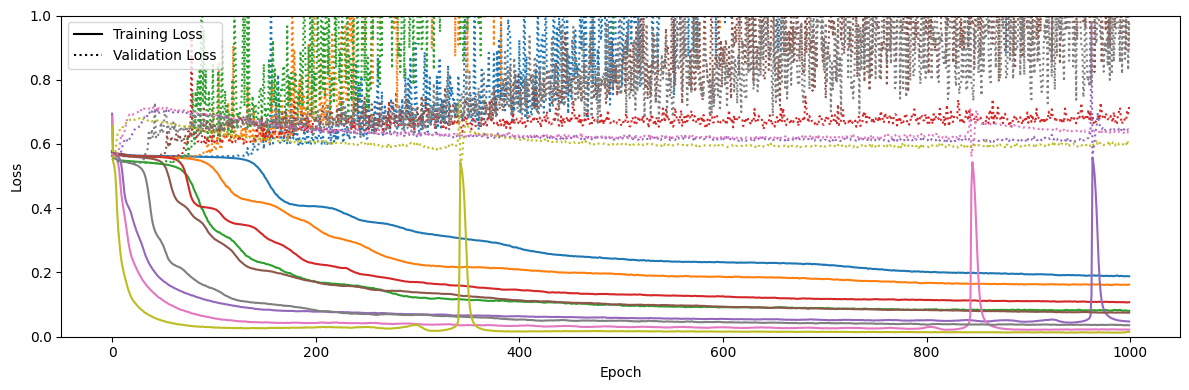

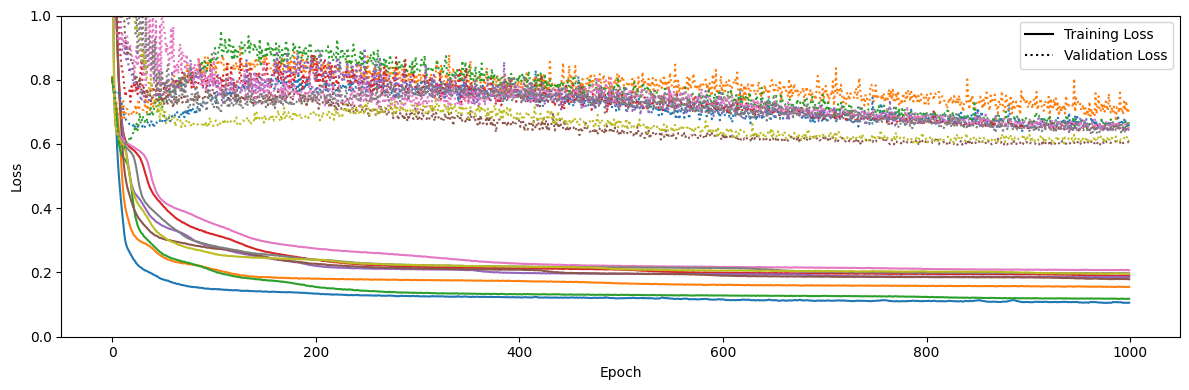

In [227]:
plot_dataframe(df_baseline, epochs=1000, name='MLPEEG', legend_loc='upper left')
plot_dataframe(df_resnet, epochs=1000, name='ResNetEEG', legend_loc='upper left')
plot_dataframe(df_resnet_latent, epochs=1000, name='ResNetLatentEEG', legend_loc='upper right')

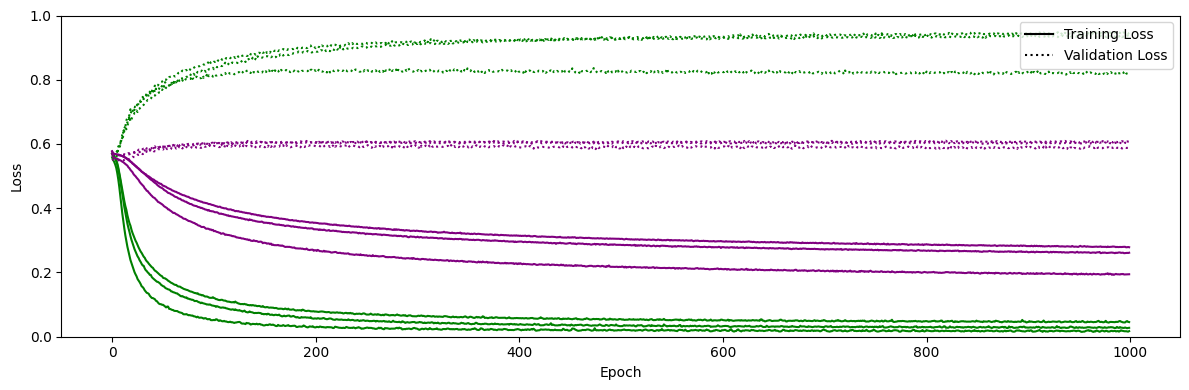

In [228]:
plot_dataframe(df_mpldropout, epochs=1000, name='MLP Dropout', legend_loc='upper right', multicolor=False)

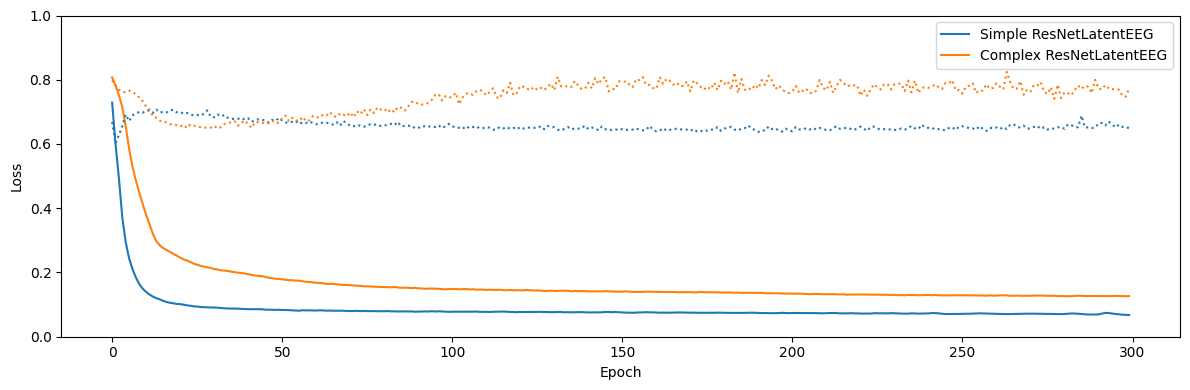

In [229]:
plot_dataframe(df_simpleresnet[:300], epochs=1000, name='Simple ResNet', legend_loc='upper right', legends=['Simple ResNetLatentEEG', 'Complex ResNetLatentEEG'], multicolor=True)


# EEG prediction visualization

Done transforming EEG data.
RMSE: [0.06980965 0.06678636 0.07807513]
Mean RMSE: 0.07155704498291016
Wasserstein Distance: 0.5143159627914429


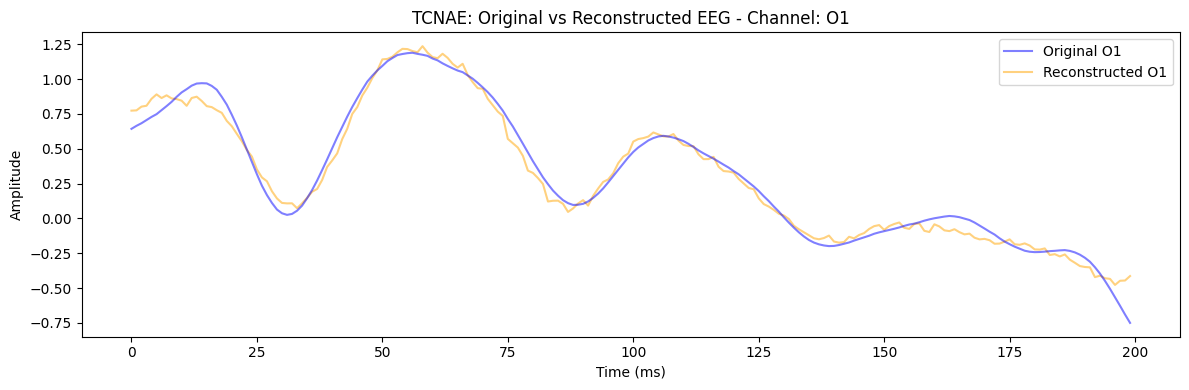

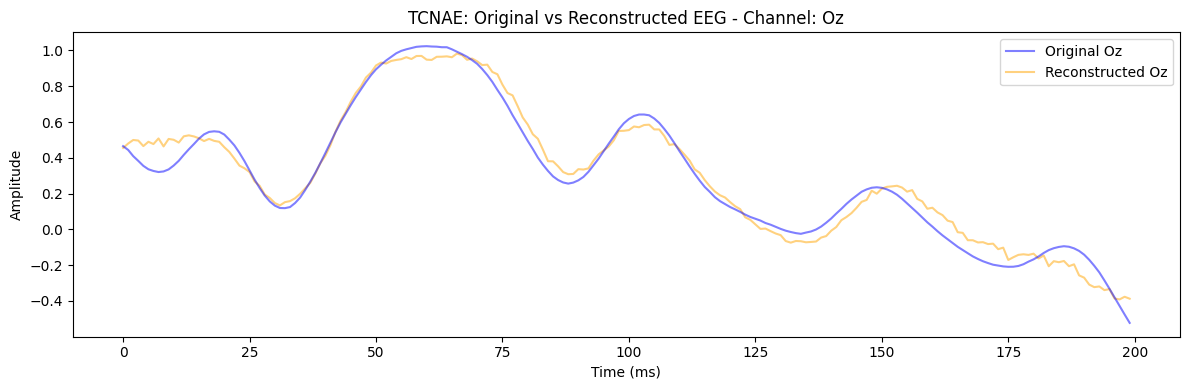

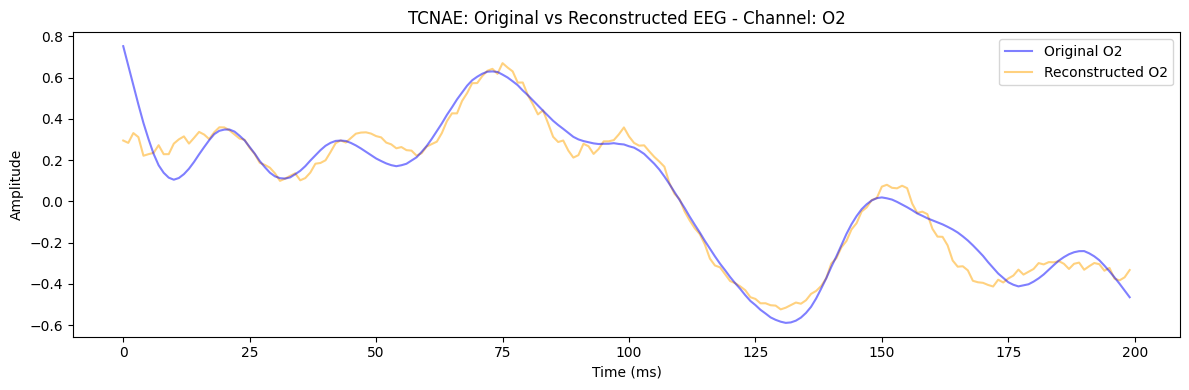

In [232]:
from utils.visualizations import plot_actual_vs_predicted_sample

model_name = '3_channels/TCNAE_3channels'

plot_actual_vs_predicted_sample(model_name, 0, fig_size=(12, 4), fig_title='TCNAE: Original vs Reconstructed EEG', single_plot=True)

# Custom loss

In [233]:
%%capture
model_path = "3_channels/ResNet_mse3_13_05_2024__15_09"
model = torch.load(f'../trained_models/{model_path}.pth', map_location=torch.device('cpu'))
model.eval()

In [234]:
tester = Tester()
outputs, targets = tester.get_predicted_and_actual_values(model, tester.test_dataloader)

Done transforming EEG data.


In [ ]:
loss_function = TimeSeriesSimilarityLoss()

# Find samples with varying results across similarity matching methods
for i in range(len(outputs)):
    for j in range(3):
        extreme_outputs, extreme_targets = loss_function.identify_extreme_points(outputs[i, j], targets[i, j])
        selected_outputs, selected_targets = loss_function.identify_candidate_fluctuation_points(extreme_outputs, extreme_targets, 1 * 1e-6 * loss_function.config.transformations.eeg.scaling)
        fluctuation_outputs, fluctuation_targets = loss_function.determine_fluctuation_points(selected_outputs, selected_targets)

        pairs = loss_function.similarity_matching(fluctuation_outputs, fluctuation_targets, 3)
        pairs_sorted = loss_function.similarity_matching_sorted(fluctuation_outputs, fluctuation_targets, 3)
        pairs_dp = loss_function.similarity_matching_dp(fluctuation_outputs, fluctuation_targets, 3)

        if (len([x for x in fluctuation_outputs if x[3]]) > 1 and len([x for x in fluctuation_targets if x[3]]) > 1) and ((len(pairs) != len(pairs_dp)) or (len(pairs_sorted) != len(pairs_dp))):
            print("Sample: " + str(i) + " Channel: " + str(j))
            # Count fluctuation points in outputs and targets
            print("Fluctuation points in outputs:", len([x for x in fluctuation_outputs if x[3]]))
            print("Fluctuation points in targets:", len([x for x in fluctuation_targets if x[3]]))
            print("Matched pairs - Current:", len(pairs))
            print("Matched pairs - Naive:", len(pairs_sorted))
            print("Matched pairs - DP:", len(pairs_dp))

In [237]:
random.seed(42)
n = 1129 #random.randint(0, 2225)
channel = 0

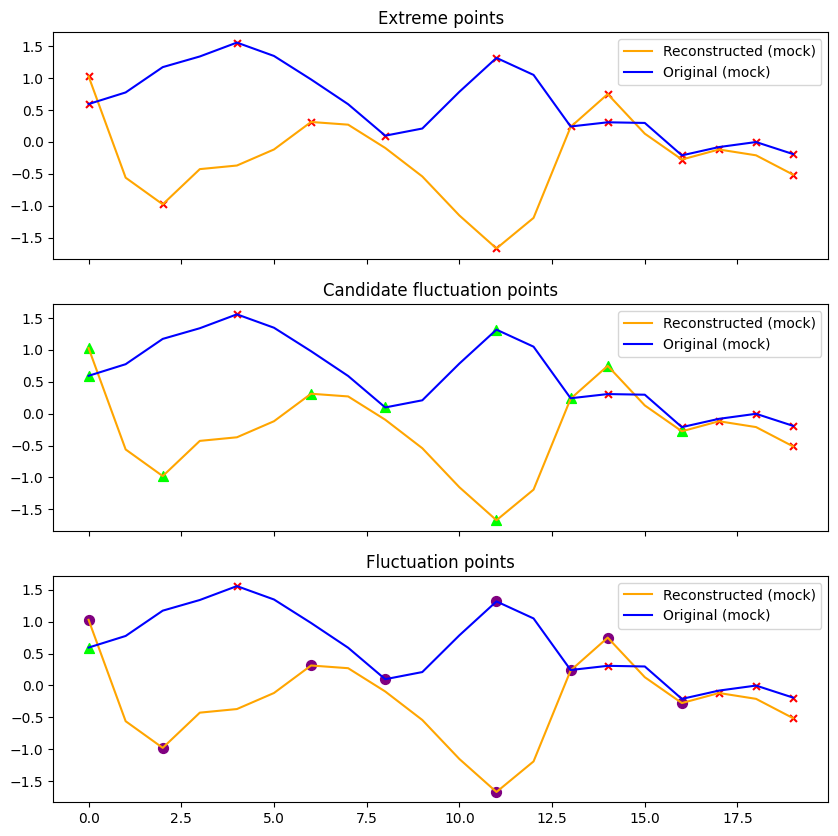

In [238]:
extreme_outputs, extreme_targets = loss_function.identify_extreme_points(outputs[n, channel], targets[n, channel])
selected_outputs, selected_targets = loss_function.identify_candidate_fluctuation_points(extreme_outputs, extreme_targets, 1 * 1e-6 * loss_function.config.transformations.eeg.scaling)
fluctuation_outputs, fluctuation_targets = loss_function.determine_fluctuation_points(selected_outputs, selected_targets)


#print(fluctuation_targets)
#print(fluctuation_outputs)

# Plot the above, but as three seperate graphs horizontally aligned
fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
ax[0].plot(outputs[n, channel], label="Reconstructed (mock)", color="orange")
ax[0].plot(targets[n, channel], label="Original (mock)", color="blue")
ax[1].plot(outputs[n, channel], label="Reconstructed (mock)", color="orange")
ax[1].plot(targets[n, channel], label="Original (mock)", color="blue")
ax[2].plot(outputs[n, channel], label="Reconstructed (mock)", color="orange")
ax[2].plot(targets[n, channel], label="Original (mock)", color="blue")

for i in range(len(selected_outputs)):
    if (selected_outputs[i][1] == 1 or selected_outputs[i][1] == -1):
        ax[0].scatter(i, selected_outputs[i][0], c="red", s=25, marker="x")
    if (selected_targets[i][1] == 1 or selected_targets[i][1] == -1):
        ax[0].scatter(i, selected_targets[i][0], c="red", s=25, marker="x")

    if (selected_outputs[i][1] == 1 or selected_outputs[i][1] == -1) and not selected_outputs[i][2]:
        ax[1].scatter(i, selected_outputs[i][0], c="red", s=25, marker="x")
    if (selected_targets[i][1] == 1 or selected_targets[i][1] == -1) and not selected_targets[i][2]:
        ax[1].scatter(i, selected_targets[i][0], c="red", s=25, marker="x")

    if selected_outputs[i][2]:
        ax[1].scatter(i, selected_outputs[i][0], c="#00FF00", s=50, marker="^")
    if selected_targets[i][2]:
        ax[1].scatter(i, selected_targets[i][0], c="#00FF00", s=50, marker="^")

    if (selected_outputs[i][1] == 1 or selected_outputs[i][1] == -1) and not selected_outputs[i][2]:
        ax[2].scatter(i, selected_outputs[i][0], c="red", s=25, marker="x")
    if (selected_targets[i][1] == 1 or selected_targets[i][1] == -1) and not selected_targets[i][2]:
        ax[2].scatter(i, selected_targets[i][0], c="red", s=25, marker="x")

    if selected_outputs[i][2] and not fluctuation_outputs[i][3]:
        ax[2].scatter(i, selected_outputs[i][0], c="#00FF00", s=50, marker="^")
    if selected_targets[i][2] and not fluctuation_targets[i][3]:
        ax[2].scatter(i, selected_targets[i][0], c="#00FF00", s=50, marker="^")

    if fluctuation_outputs[i][3]:
        ax[2].scatter(i, fluctuation_outputs[i][0], c="purple", s=50, marker="o")
    if fluctuation_targets[i][3]:
        ax[2].scatter(i, fluctuation_targets[i][0], c="purple", s=50, marker="o")

ax[0].legend()
ax[0].set_title("Extreme points")
ax[1].legend()
ax[1].set_title("Candidate fluctuation points")
ax[2].legend()
ax[2].set_title("Fluctuation points")

plt.show()

In [239]:
pairs = loss_function.similarity_matching(fluctuation_outputs, fluctuation_targets, 3)
pairs_sorted = loss_function.similarity_matching_sorted(fluctuation_outputs, fluctuation_targets, 3)
pairs_dp = loss_function.similarity_matching_dp(fluctuation_outputs, fluctuation_targets, 3)
# Count fluctuation points in outputs and targets
print("Fluctuation points in outputs:", len([x for x in fluctuation_outputs if x[3]]))
print("Fluctuation points in targets:", len([x for x in fluctuation_targets if x[3]]))
print("Matched pairs - Current:", len(pairs))
print("Matched pairs - Naive:", len(pairs_sorted))
print("Matched pairs - DP:", len(pairs_dp))

Fluctuation points in outputs: 6
Fluctuation points in targets: 3
Matched pairs - Current: 2
Matched pairs - Naive: 2
Matched pairs - DP: 3


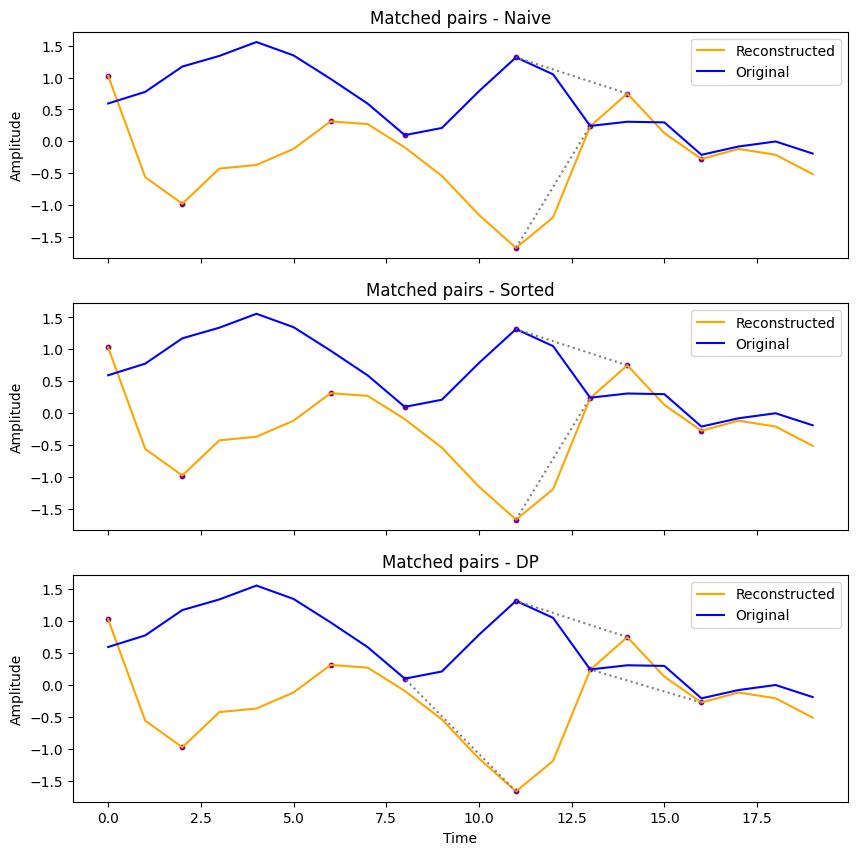

In [240]:
# Plot fluctuation_outputs
fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
ax[0].plot(outputs[n, channel], label="Reconstructed", color="orange")
ax[0].plot(targets[n, channel], label="Original", color="blue")
ax[1].plot(outputs[n, channel], label="Reconstructed", color="orange")
ax[1].plot(targets[n, channel], label="Original", color="blue")
ax[2].plot(outputs[n, channel], label="Reconstructed", color="orange")
ax[2].plot(targets[n, channel], label="Original", color="blue")

for i in range(len(selected_outputs)):
    if fluctuation_outputs[i][3]:
        ax[0].scatter(i, fluctuation_outputs[i][0], c="purple", s=10, marker="o")
    if fluctuation_targets[i][3]:
        ax[0].scatter(i, fluctuation_targets[i][0], c="purple", s=10, marker="o")

    if fluctuation_outputs[i][3]:
        ax[1].scatter(i, fluctuation_outputs[i][0], c="purple", s=10, marker="o")
    if fluctuation_targets[i][3]:
        ax[1].scatter(i, fluctuation_targets[i][0], c="purple", s=10, marker="o")

    if fluctuation_outputs[i][3]:
        ax[2].scatter(i, fluctuation_outputs[i][0], c="purple", s=10, marker="o")
    if fluctuation_targets[i][3]:
        ax[2].scatter(i, fluctuation_targets[i][0], c="purple", s=10, marker="o")

for pair in pairs:
    ax[0].plot([pair[0], pair[1]], [fluctuation_outputs[pair[0]][0], fluctuation_targets[pair[1]][0]], c="gray", linestyle="dotted")
ax[0].set_title("Matched pairs - Naive")
ax[0].legend()
ax[0].set_ylabel("Amplitude")

# Plot fluctuation_outputs for naive solution
for pair in pairs_sorted:
    ax[1].plot([pair[0], pair[1]], [fluctuation_outputs[pair[0]][0], fluctuation_targets[pair[1]][0]], c="gray", linestyle="dotted")
ax[1].set_title("Matched pairs - Sorted")
ax[1].legend()
ax[1].set_ylabel("Amplitude")

# Plot fluctuation_outputs for DP solution
for pair in pairs_dp:
    ax[2].plot([pair[0], pair[1]], [fluctuation_outputs[pair[0]][0], fluctuation_targets[pair[1]][0]], c="gray", linestyle="dotted")
ax[2].set_title("Matched pairs - DP")
ax[2].legend()
ax[2].set_ylabel("Amplitude")
ax[2].set_xlabel("Time")

plt.show()

In [241]:
# Distance
loss_function.compute_distance(fluctuation_outputs, fluctuation_targets, pairs)

tensor(3.9797)

# Spectrum Density Plots

In [242]:
%%capture
model_path = "3_channels/TCNAE_3channels"
model = torch.load(f'../trained_models/{model_path}.pth', map_location=torch.device('cpu'))
model.eval()

In [244]:
tester = Tester()
reconstructed, target = tester.get_predicted_and_actual_values(model, tester.test_dataloader)

Done transforming EEG data.


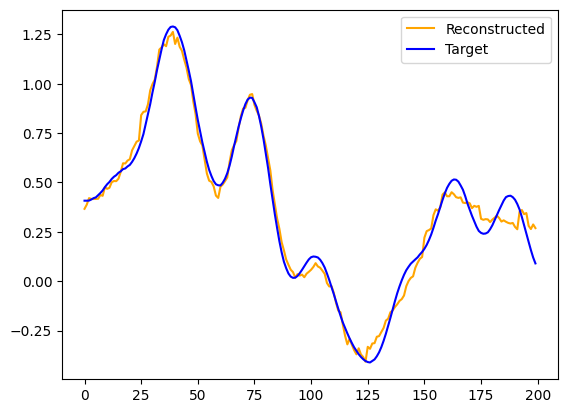

In [245]:
# Plot example of each
plt.plot(reconstructed[2000, 0], label="Reconstructed", color="orange")
plt.plot(target[2000, 0], label="Target" , color="blue")
plt.legend()
plt.show()

In [246]:
import scipy.signal as signal
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch

channels = ['O1', 'Oz', 'O2']
fs = 1000 # Sampling rate
win_len = 200 # Window length

In [247]:
# Reshape the data from (2225, 3, 200) to (2225*200, 3)
reconstructed_reshaped = reconstructed.reshape(-1, 3)
target_reshaped = target.reshape(-1, 3)

print(reconstructed_reshaped.shape)
print(target_reshaped.shape)

(445000, 3)
(445000, 3)


In [248]:
def compute_psd(data, fs=1.0):
    psd_list = []
    freqs_list = []
    for channel in range(data.shape[1]):
        channel_data = data[:, channel]
        freqs, psd = welch(channel_data, fs=fs, nperseg=win_len, axis=0)
        psd_list.append(psd)
        freqs_list.append(freqs)
    return freqs_list, psd_list

def compute_psd_with_std(data, fs=1.0, win_len=200, n_segments=10):
    segment_len = data.shape[0] // n_segments
    psds = np.zeros((n_segments, data.shape[1], win_len//2+1))
    
    for i in range(n_segments):
        segment_data = data[i*segment_len:(i+1)*segment_len, :]
        _, segment_psds = compute_psd(segment_data, fs)
        psds[i] = segment_psds
    
    psd_mean = np.mean(psds, axis=0)
    psd_std = np.std(psds, axis=0)
    freqs = welch(data[:, 0], fs=fs, nperseg=win_len, axis=0)[0]
    return freqs, psd_mean, psd_std

# Same as above but for a single channel, e.g. instead of (444500, 3) input it is now (444500*3,)
# Also include std, dont use compute_psd_with_std
def compute_psd_with_std_single_channel(data, fs=1.0, win_len=200, n_segments=10):
    segment_len = data.shape[0] // n_segments
    psds = np.zeros((n_segments, win_len//2+1))

    for i in range(n_segments):
        segment_data = data[i*segment_len:(i+1)*segment_len]
        _, segment_psds = welch(segment_data, fs=fs, nperseg=win_len, axis=0)
        psds[i] = segment_psds

    psd_mean = np.mean(psds, axis=0)
    psd_std = np.std(psds, axis=0)
    freqs = welch(data, fs=fs, nperseg=win_len, axis=0)[0]
    return freqs, psd_mean, psd_std       


## Plot PSD

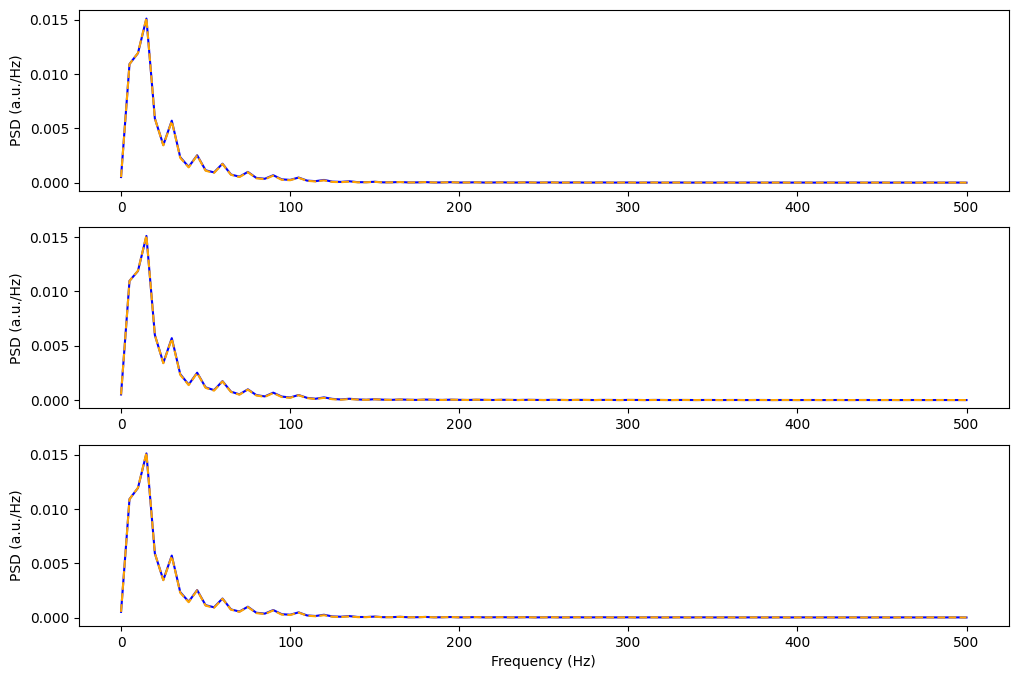

In [249]:
target_freqs, target_psds = compute_psd(target_reshaped, fs=fs)
reconstructed_freqs, reconstructed_psds = compute_psd(reconstructed_reshaped, fs=fs)

# Plot the power spectrum
plt.figure(figsize=(12, 8))
for i in range(len(channels)):
    plt.subplot(3, 1, i+1)
    plt.plot(target_freqs[i], target_psds[i],  color='blue')
    plt.plot(reconstructed_freqs[i], reconstructed_psds[i], linestyle='--', color='orange')
    plt.ylabel('PSD (a.u./Hz)')

plt.xlabel('Frequency (Hz)')
plt.show()

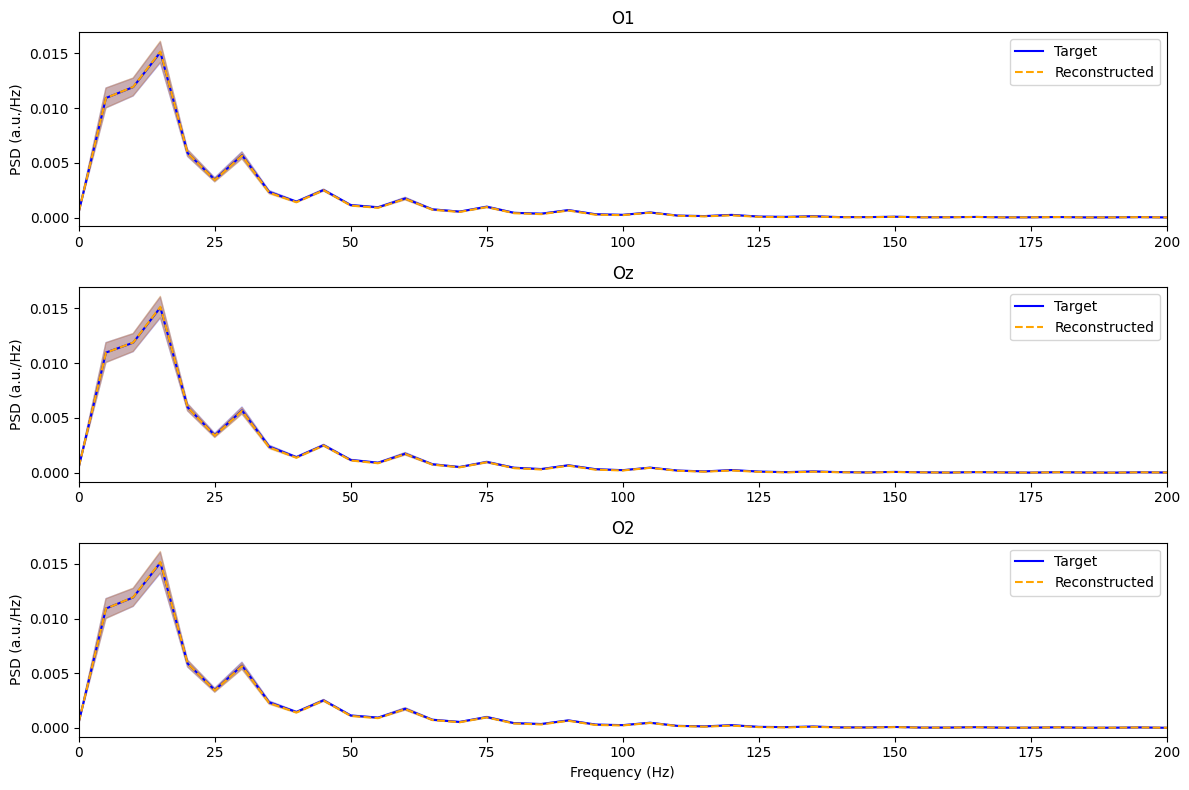

In [250]:
target_freqs, target_psd_mean, target_psd_std = compute_psd_with_std(target_reshaped, fs=fs)
reconstructed_freqs, reconstructed_psd_mean, reconstructed_psd_std = compute_psd_with_std(reconstructed_reshaped, fs=fs)

# Plot the power spectrum with standard deviation shading
plt.figure(figsize=(12, 8))

for i in range(len(channels)):
    ax = plt.subplot(3, 1, i+1)
    ax.plot(target_freqs, target_psd_mean[i], color='blue', label='Target')
    ax.fill_between(target_freqs, target_psd_mean[i] - target_psd_std[i], target_psd_mean[i] + target_psd_std[i], color='blue', alpha=0.3)
    ax.plot(reconstructed_freqs, reconstructed_psd_mean[i], linestyle='--', color='orange', label='Reconstructed')
    ax.fill_between(reconstructed_freqs, reconstructed_psd_mean[i] - reconstructed_psd_std[i], reconstructed_psd_mean[i] + reconstructed_psd_std[i], color='orange', alpha=0.3)
    if i+1 == len(channels):
        ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('PSD (a.u./Hz)')
    ax.set_title(channels[i])
    ax.legend()
    ax.set_xlim([0, 200])  # Adjust the x-axis limits here

plt.tight_layout()
plt.show()

## Plot PSD on difference

In [251]:
signal_diff = target_reshaped - reconstructed_reshaped

In [252]:
reconstructed_reshaped.shape

(445000, 3)

In [253]:
signal_diff_reshaped = signal_diff.reshape(-1)
signal_diff_reshaped.shape

(1335000,)

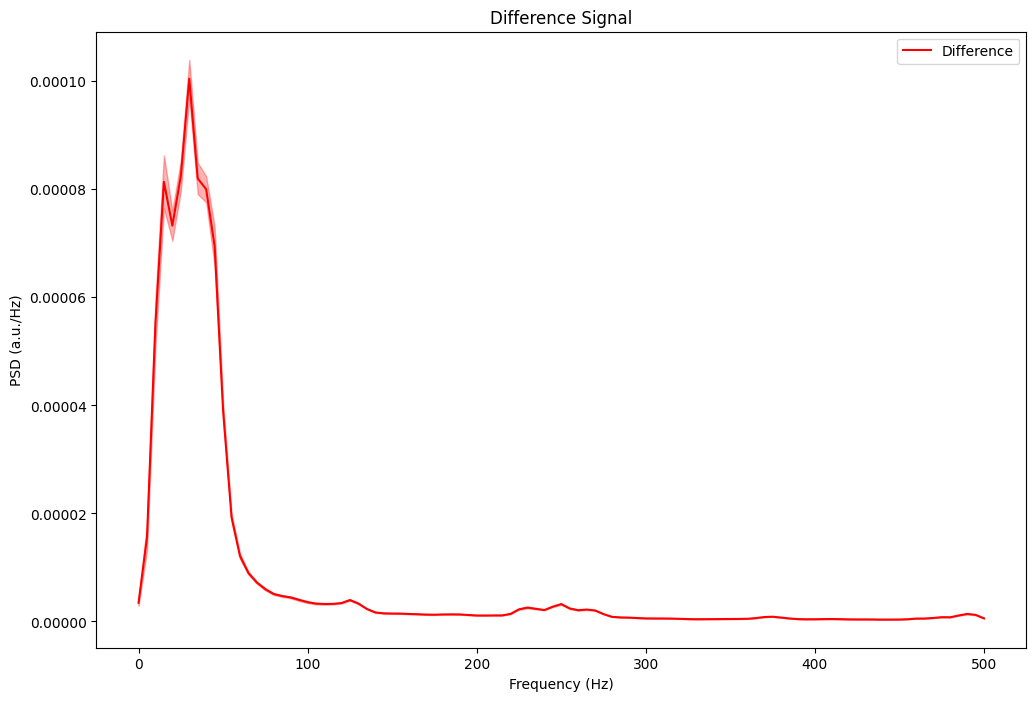

In [254]:
signal_diff_freqs, signal_diff_psd_mean, signal_diff_psd_std = compute_psd_with_std_single_channel(signal_diff_reshaped, fs=fs)

# Plot the power spectrum of the difference signal
plt.figure(figsize=(12, 8))

plt.plot(signal_diff_freqs, signal_diff_psd_mean, color='red', label='Difference')
plt.fill_between(signal_diff_freqs, signal_diff_psd_mean - signal_diff_psd_std, signal_diff_psd_mean + signal_diff_psd_std, color='red', alpha=0.3)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (a.u./Hz)')
plt.title('Difference Signal')
plt.legend()
#plt.xlim([0, 200])  # Adjust the x-axis limits here

plt.show()


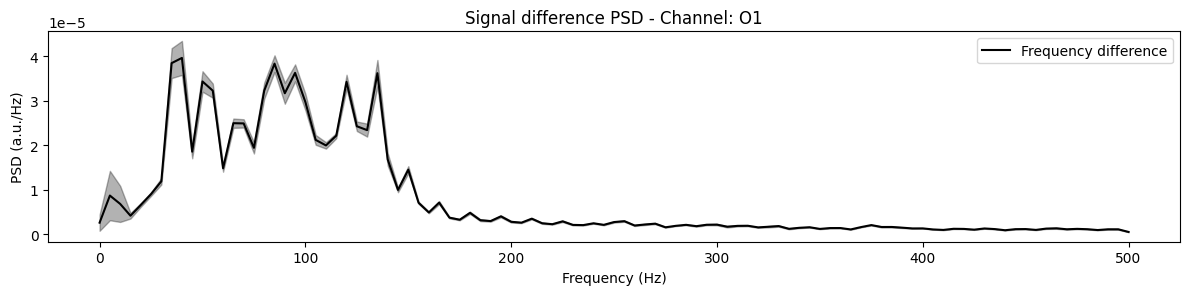

In [255]:
signal_diff_freqs, signal_diff_psd_mean, signal_diff_psd_std = compute_psd_with_std(signal_diff, fs=fs)

# Plot the power spectrum of the difference signal
plt.figure(figsize=(12, 8))

for i in range(1):
    ax = plt.subplot(3, 1, i+1)
    ax.plot(signal_diff_freqs, signal_diff_psd_mean[i], color='k', label='Frequency difference')
    ax.fill_between(signal_diff_freqs, signal_diff_psd_mean[i] - signal_diff_psd_std[i], signal_diff_psd_mean[i] + signal_diff_psd_std[i], color='k', alpha=0.3)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('PSD (a.u./Hz)')
    ax.set_title(f'Signal difference PSD - Channel: {channels[i]}')
    ax.legend()
    #ax.set_xlim([0, 200])  # Adjust the x-axis limits here

plt.tight_layout()
plt.show()

# RSA

In [258]:
%%capture
rsa_model_path = "3_channels/ResNet_mse4_13_05_2024__14_16"
model = torch.load(f'../trained_models/{rsa_model_path}.pth', map_location=torch.device('cpu'))
model.eval()

In [259]:
tester = Tester()
rsa_reconstructed, rsa_target = tester.get_predicted_and_actual_values(model, tester.test_dataloader)

Done transforming EEG data.


In [260]:
rsa1 = RepresentationalSimilarityAnalysis(rsa_target, similarity_metric='rmse')


Calculating RMSE distances: 100%|██████████| 2225/2225 [00:41<00:00, 53.54it/s]


In [261]:
rsa2 = RepresentationalSimilarityAnalysis(rsa_reconstructed, similarity_metric='rmse')

Calculating RMSE distances: 100%|██████████| 2225/2225 [00:41<00:00, 53.03it/s]


In [262]:
import numpy as np
import scipy.stats as stats
from scipy.spatial import procrustes
from sklearn.manifold import MDS

print(rsa_model_path)

# 1. Flatten the upper triangular parts of the RDMs
def flatten_upper_triangular(matrix):
    return matrix[np.triu_indices_from(matrix, k=1)]

flattened_rsa1 = flatten_upper_triangular(rsa1.rdm)
flattened_rsa2 = flatten_upper_triangular(rsa2.rdm)

# 2. Statistical Comparison
print(' ')
print('Statistical Comparison')
# Pearson Correlation
pearson_corr, pearson_p_value = stats.pearsonr(flattened_rsa1, flattened_rsa2)
print(f'Pearson Correlation: {pearson_corr}, p-value: {pearson_p_value}')

# Spearman Correlation
spearman_corr, spearman_p_value = stats.spearmanr(flattened_rsa1, flattened_rsa2)
print(f'Spearman Correlation: {spearman_corr}, p-value: {spearman_p_value}')

3_channels/ResNet_mse4_13_05_2024__14_16
 
Statistical Comparison
Pearson Correlation: 0.03363391325529198, p-value: 0.0
Spearman Correlation: 0.0356875535454914, p-value: 0.0


C:\Users\simon\AppData\Local\Temp\ipykernel_20040\3860966751.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


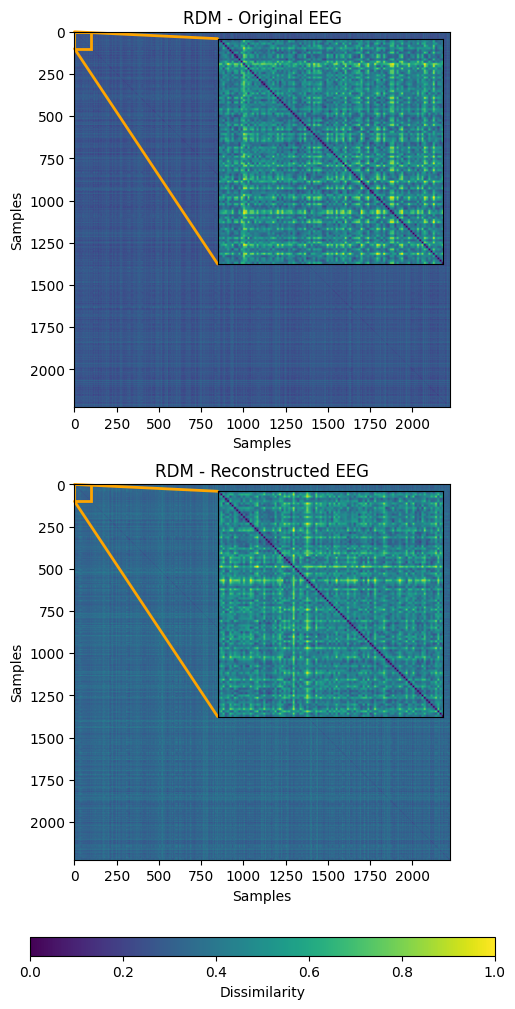

In [264]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch

# Assuming rsa1 and rsa2 are already defined with their respective RDMs
# rsa1.rdm and rsa2.rdm are the RDM matrices

inset_start = 0
inset_size = 100

# Create a figure with GridSpec to allocate space for the colorbar
fig = plt.figure(figsize=(6, 12))
gs = GridSpec(3, 1, height_ratios=[1, 1, 0.05], hspace=0.3)

# First plot
ax1 = fig.add_subplot(gs[0])
im1 = ax1.imshow(rsa1.rdm, cmap='viridis')
ax1.set_title('RDM - Original EEG')
ax1.set_ylabel('Samples')
ax1.set_xlabel('Samples')

# Add inset to the first plot
axins1 = inset_axes(ax1, width="60%", height="60%", loc='upper right')
axins1.imshow(rsa1.rdm[inset_start:inset_start+inset_size, inset_start:inset_start+inset_size], cmap='viridis')
axins1.set_xticks([])
axins1.set_yticks([])

# Add rectangle to indicate the inset region
rect1 = patches.Rectangle((inset_start, inset_start), inset_size, inset_size, linewidth=2, edgecolor='orange', facecolor='none')
ax1.add_patch(rect1)

# Second plot
ax2 = fig.add_subplot(gs[1])
im2 = ax2.imshow(rsa2.rdm, cmap='viridis')
ax2.set_title('RDM - Reconstructed EEG')
ax2.set_ylabel('Samples')
ax2.set_xlabel('Samples')

# Add inset to the second plot
axins2 = inset_axes(ax2, width="60%", height="60%", loc='upper right')
axins2.imshow(rsa2.rdm[inset_start:inset_start+inset_size, inset_start:inset_start+inset_size], cmap='viridis')
axins2.set_xticks([])
axins2.set_yticks([])

# Add rectangle to indicate the inset region
rect2 = patches.Rectangle((inset_start, inset_start), inset_size, inset_size, linewidth=2, edgecolor='orange', facecolor='none')
ax2.add_patch(rect2)

# Function to get corners of the rectangle in data coordinates
def get_rect_corners(rect):
    x0, y0 = rect.get_x(), rect.get_y()
    x1, y1 = x0 + rect.get_width(), y0 + rect.get_height()
    return [(x0, y0), (x1, y0), (x0, y1), (x1, y1)]

# Draw lines between the corners of the orange box and the inset
for ax, axins, rect in zip([ax1, ax2], [axins1, axins2], [rect1, rect2]):
    rect_corners = get_rect_corners(rect)

    con = ConnectionPatch(xyA=(rect_corners[0]), xyB=(0, 1), coordsA="data", coordsB="axes fraction",
                            axesA=ax, axesB=axins, color="orange", linewidth=2)
    ax.add_artist(con)

    con = ConnectionPatch(xyA=(rect_corners[2]), xyB=(0, 0), coordsA="data", coordsB="axes fraction",
                            axesA=ax, axesB=axins, color="orange", linewidth=2)
    ax.add_artist(con)

# Shared colorbar
cax = fig.add_subplot(gs[2])
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal')
cbar.set_label('Dissimilarity')

plt.tight_layout()
plt.show()


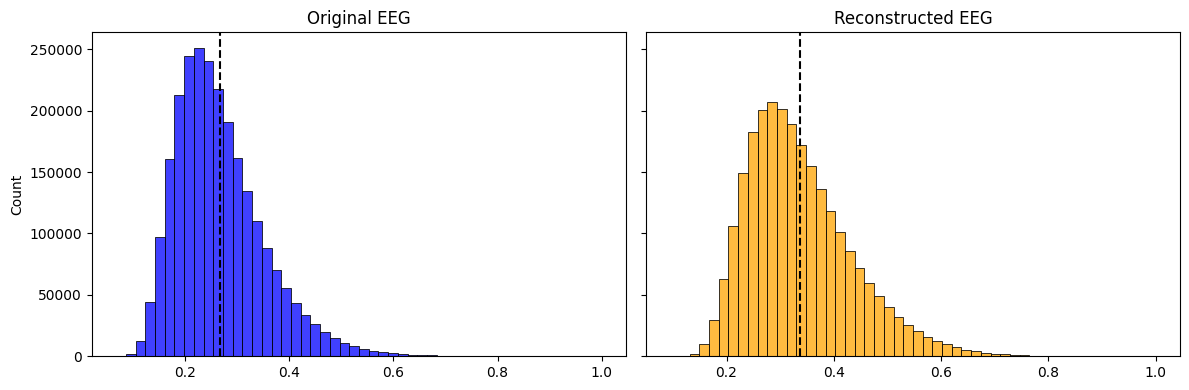

In [265]:
# import sns
import seaborn as sns

# Determine the number of bins based on the data
num_bins = 50

# Plot distirbutions of the RDMs and a line for their mean in two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sns.histplot(flattened_rsa1, ax=ax[0], color='blue', label='Original EEG', bins=num_bins)
sns.histplot(flattened_rsa2, ax=ax[1], color='orange', label='Reconstructed EEG', bins=num_bins)
ax[0].axvline(np.mean(flattened_rsa1), color='k', linestyle='--', label='Mean')
ax[1].axvline(np.mean(flattened_rsa2), color='k', linestyle='--', label='Mean')
ax[0].set_title('Original EEG')
ax[1].set_title('Reconstructed EEG')
plt.tight_layout()
plt.show()

# Class, Channel and Error Distribution Inspection

## Sample Error Distribution Across Channels

In [271]:
from metrics.lossfunctions import ApproxWassersteinDistanceLoss, TimeSeriesSimilarityLoss
from metrics.performance_metrics import EEGChallengeScore
from sklearn.metrics import root_mean_squared_error

def compute_individual_sample_errors(predicted_values, actual_values):
    def compute_rmse(predicted_values, actual_values):
        actual_values = actual_values.flatten()
        predicted_values = predicted_values.flatten()
        rmse = root_mean_squared_error(actual_values, predicted_values)
        return rmse
    
    # Wasserstein distance
    def compute_wasserstein_distance(predicted_values, actual_values):
        predicted_values_tensor = torch.from_numpy(predicted_values).float()  # Convert to float tensor
        actual_values_tensor = torch.from_numpy(actual_values).float()

        wasserstein = ApproxWassersteinDistanceLoss()
        return wasserstein(predicted_values_tensor, actual_values_tensor)
    
    # Algonauts Challenge Score
    def compute_algonauts_challenge_score(predicted_values, actual_values):
        acs = EEGChallengeScore(predicted_values, actual_values)
        score_per_channel, total_score = acs.compute_scores()

        return score_per_channel, total_score
    
    individual_sample_errors = []
    for sample in range(len(predicted_values)):
        rmse = compute_rmse(predicted_values[sample], actual_values[sample])
        #wasserstein = compute_wasserstein_distance(predicted_values[sample], actual_values[sample])
        #_, acs = compute_algonauts_challenge_score(predicted_values[sample], actual_values[sample])

        individual_sample_errors.append(rmse)
    
    return individual_sample_errors

In [286]:
tester = Tester()
model_path = "../trained_models/3_channels/ResNet_mse4_13_05_2024__14_16.pth"
model = torch.load(model_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
predicted_values, actual_values = tester.get_predicted_and_actual_values(model, tester.test_dataloader)

Done transforming EEG data.


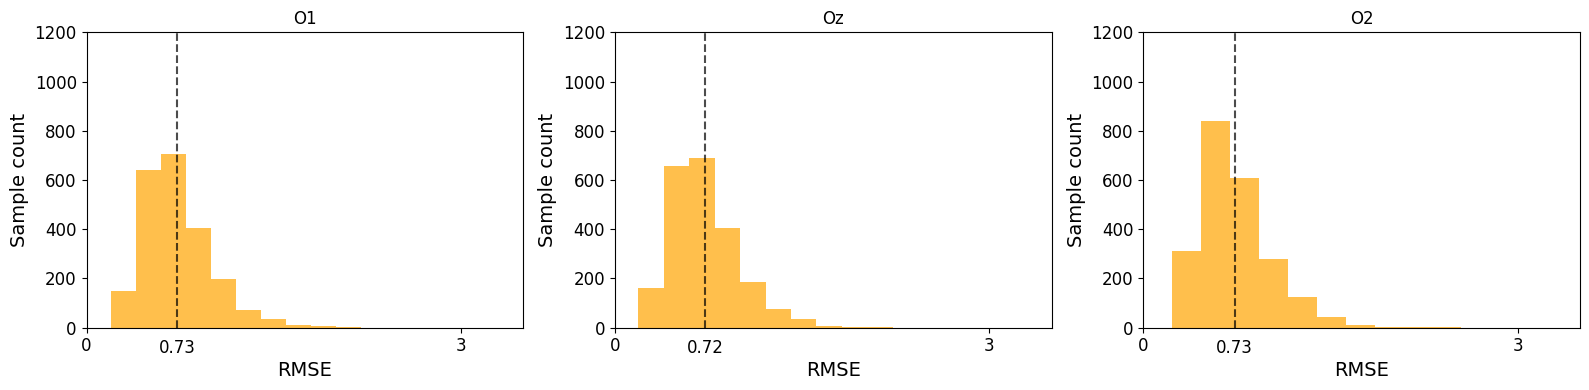

In [287]:
import matplotlib.pyplot as plt
import numpy as np

channels = ["O1", "Oz", "O2"]

if len(channels) == 11:
    figsize = (20, 3)
elif len(channels) == 5:
    figsize = (10, 3)
elif len(channels) == 3:
    figsize = (16, 4)

fig, axes = plt.subplots(1, len(channels), figsize=figsize)

for i, channel in enumerate(channels):
    individual_sample_errors = compute_individual_sample_errors(predicted_values[:, i, :], actual_values[:, i, :])
    counts, bins = np.histogram(individual_sample_errors)
    ax = axes[i]  # Get the current axis
    ax.stairs(counts, bins, fill=True, color='orange', alpha=0.7)
    mean_value = np.mean(individual_sample_errors)
    # plot the mean 
    ax.axvline(mean_value, color='k', linestyle='--', label='Mean', alpha=0.7)
    if mean_value < 3.6:
        ax.annotate(f'{mean_value:.2f}', xy=(mean_value, 0), xytext=(0, -18),
                    textcoords='offset points', ha='center', color='k', fontsize=12)
    if i == 0:
        ax.set_ylabel("Sample count")
    ax.set_xlabel("RMSE")
    ax.set_xlim((0, 3.5))
    ax.set_xticks([0, 3])
    ax.set_ylim((0, 1200))
    ax.set_title(channel)

    # Increase label and tick sizes
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel("RMSE", fontsize=14)
    ax.set_ylabel("Sample count", fontsize=14)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


## Additional

In [ ]:
tester = Tester()
model_name = '3_channels/ResNet_mse4_13_05_2024__14_16'
model = torch.load(f'..\\trained_models\\{model_name}.pth', map_location=torch.device('cpu'))
predicted_values, actual_values = tester.get_predicted_and_actual_values(model, tester.test_dataloader)
print(predicted_values.shape)

In [ ]:
class_encoding_file_path = f'../data/datasets/one_person/EEG_classencoding_testdata.npy.gz'
with gzip.GzipFile(class_encoding_file_path, "r") as f:
    test_data_classes = torch.from_numpy(np.load(file=f))
print(test_data_classes.shape)

In [268]:
def get_testset_classes():
    # Load class encodings from test data
    with gzip.GzipFile(class_encoding_file_path, "r") as f:
        test_data_classes = torch.from_numpy(np.load(file=f))

    # Load classes from things_csv
    tsv_file_path = '../data/meta/things_concepts.tsv'
    with open(tsv_file_path) as file:
        tsv_file = csv.DictReader(file, delimiter="\t")
        classes = []
        for row in tsv_file:
            classes.append(row['uniqueID'])

    testset_classes = []
    # Find out which class the index matches to
    for sample in range(len(test_data_classes)):
        for i in range(len(test_data_classes[0])):
            if test_data_classes[sample, i] == 1:
                testset_classes.append(classes[i]+f'({i})')
    
    return testset_classes

In [269]:
from metrics.lossfunctions import ApproxWassersteinDistanceLoss, TimeSeriesSimilarityLoss
from metrics.performance_metrics import EEGChallengeScore
from sklearn.metrics import root_mean_squared_error

def compute_individual_sample_errors(predicted_values, actual_values):
    def compute_rmse(predicted_values, actual_values):
        actual_values = actual_values.flatten()
        predicted_values = predicted_values.flatten()
        rmse = root_mean_squared_error(actual_values, predicted_values)
        return rmse
    
    # Wasserstein distance
    def compute_wasserstein_distance(predicted_values, actual_values):
        predicted_values_tensor = torch.from_numpy(predicted_values).float()  # Convert to float tensor
        actual_values_tensor = torch.from_numpy(actual_values).float()

        wasserstein = ApproxWassersteinDistanceLoss()
        return wasserstein(predicted_values_tensor, actual_values_tensor)
    
    # Algonauts Challenge Score
    def compute_algonauts_challenge_score(predicted_values, actual_values):
        acs = EEGChallengeScore(predicted_values, actual_values)
        score_per_channel, total_score = acs.compute_scores()

        return score_per_channel, total_score
    
    individual_sample_errors = []
    for sample in range(len(predicted_values)):
        rmse = compute_rmse(predicted_values[sample], actual_values[sample])
        #wasserstein = compute_wasserstein_distance(predicted_values[sample], actual_values[sample])
        #_, acs = compute_algonauts_challenge_score(predicted_values[sample], actual_values[sample])

        individual_sample_errors.append(rmse)
    
    return individual_sample_errors

In [ ]:
import os
import glob
import csv

print('Getting classes for the testset')
testset_classes = get_testset_classes()
baseline_class_distribution_values = []
resneteeg_class_distribution_values = []
resnetlatenteeg_class_distribution_values = []
top_classes = []
bottom_classes = []

trained_models_path = f"../trained_models"

# Iterate over each subfolder (channel subset) in the trained_models folder
for subfolder_name in os.listdir(trained_models_path):
    subfolder_path = os.path.join(trained_models_path, subfolder_name)
    
    # Check if the current path is a directory (i.e., a subfolder of channel subset)
    if os.path.isdir(subfolder_path):
        print(f'Accessing files in subfolder: {subfolder_path}')
        
        # Iterate over each file in the subfolder
        for model_path in glob.glob(os.path.join(subfolder_path, '*')):
            if os.path.isfile(model_path):
                # Do not test on TCNAE
                if ('TCNAE' in model_path) or ('dropout' in model_path):
                    continue
                print(f'Model found: {model_path}')

                # Setup configs specific to current model
                changing_model_configs = {}
                # Changing based on model name
                if 'Latent' in model_path:
                    changing_model_configs = {
                        'new_freq': 1000,
                        'batch_size': 128
                    }
                elif 'Baseline' in model_path:
                    changing_model_configs = {
                        'new_freq': 100,
                        'batch_size': 128
                    }
                else:
                    changing_model_configs = {
                        'new_freq': 100,
                        'batch_size': 256
                    }
                # Changing channels
                if '3' in subfolder_path:
                    changing_model_configs['used_channels'] = ['O1', 'Oz', 'O2']
                elif '5' in subfolder_path:
                    if 'Latent' in model_path:
                        continue
                    changing_model_configs['used_channels'] = ['O1', 'Oz', 'O2', 'T7', 'T8']
                elif '11' in subfolder_path:
                    if 'Latent' in model_path:
                        continue
                    changing_model_configs['used_channels'] = ['O1', 'Oz', 'O2', 'T7', 'T8', 'TP7', 'TP8', 'P7', 'P8', 'PO7', 'PO8']
                # Changing model name

                # Changing resnet blocks

                # Setup tester and find predicted/actual:
                #tester = Tester()
                tester = Tester(changing_model_configs=changing_model_configs)
                model = torch.load(model_path, map_location=torch.device('cpu'))
                predicted_values, actual_values = tester.get_predicted_and_actual_values(model, tester.test_dataloader)
                # Test on predicted and actual
                individual_sample_errors = compute_individual_sample_errors(predicted_values, actual_values)
                if 'Baseline' in model_path:
                    baseline_class_distribution_values.append(individual_sample_errors)
                elif 'Latent' in model_path:
                    resnetlatenteeg_class_distribution_values.append(individual_sample_errors)
                else:
                    resneteeg_class_distribution_values.append(individual_sample_errors)

                zipped_errors_classes = zip(individual_sample_errors, testset_classes)
                zipped_errors_classes_sorted = sorted(zipped_errors_classes, key=lambda x: x[0], reverse=False)
                individual_sample_errors_sorted, testset_classes_sorted = zip(*zipped_errors_classes_sorted)
                print('Top 5 classes RMSEs:')
                print(individual_sample_errors_sorted[0:5])
                print('with classes:')
                print(testset_classes_sorted[0:5])
                top_classes.append(testset_classes_sorted[0:5])
                print('Bottom 5 classes RMSEs:')
                print(individual_sample_errors_sorted[-5:])
                print('with classes:')
                print(testset_classes_sorted[-5:])
                bottom_classes.append(individual_sample_errors_sorted[-5:])
                print('===================')

# Find if we spotted any specific classes being in top or bottom across different models
top_classes = [
    x
    for xs in top_classes
    for x in xs
]
newlist = []
duplist = []
for i in top_classes:
    if i not in newlist:
        newlist.append(i)
    else:
        duplist.append(i)
print('Classes seen in top across models:', duplist)
bottom_classes = [
    x
    for xs in bottom_classes
    for x in xs
]
newlist = []
duplist = []
for i in bottom_classes:
    if i not in newlist:
        newlist.append(i)
    else:
        duplist.append(i)
print('Classes seen in bottom across models:', duplist)

In [ ]:
# Optionally, only use the best model setting for each category (to have more equal RMSEs in the following plots)
baseline_class_distribution_values_best = baseline_class_distribution_values[1] # Baseline on 3 channels, no dropout
resneteeg_class_distribution_values_best = resneteeg_class_distribution_values[5] # ResNetEEG on 3 channels 4 resnet modules
resnetlatenteeg_class_distribution_values_best = resnetlatenteeg_class_distribution_values[2] # ResNetLatentEEG on 3 channels 4 resnet modules

# Compute means of class distribution errors
#baseline_class_distribution_values_mean = np.mean(baseline_class_distribution_values, axis=1)
#resneteeg_class_distribution_values_mean = np.mean(resneteeg_class_distribution_values, axis=1)
#resnetlatenteeg_class_distribution_values_mean = np.mean(resnetlatenteeg_class_distribution_values, axis=1)

zipped_errors_classes = zip(baseline_class_distribution_values_best, testset_classes)
zipped_errors_classes_sorted = sorted(zipped_errors_classes, key=lambda x: x[0], reverse=False)
baseline_mean_errors_sorted, baseline_class_distribution_sorted = zip(*zipped_errors_classes_sorted)

zipped_errors_classes = zip(resneteeg_class_distribution_values_best, testset_classes)
zipped_errors_classes_sorted = sorted(zipped_errors_classes, key=lambda x: x[0], reverse=False)
resneteeg_mean_errors_sorted, resneteeg_class_distribution_sorted = zip(*zipped_errors_classes_sorted)

zipped_errors_classes = zip(resnetlatenteeg_class_distribution_values_best, testset_classes)
zipped_errors_classes_sorted = sorted(zipped_errors_classes, key=lambda x: x[0], reverse=False)
resnetlatenteeg_mean_errors_sorted, resnetlatenteeg_class_distribution_sorted = zip(*zipped_errors_classes_sorted)

print('Baseline:')
print(baseline_mean_errors_sorted)
print(baseline_class_distribution_sorted)
print('ResNetEEG:')
print(resneteeg_mean_errors_sorted)
print(resneteeg_class_distribution_sorted)
print('ResNetLatentEEG:')
print(resnetlatenteeg_mean_errors_sorted)
print(resnetlatenteeg_class_distribution_sorted)

In [ ]:
# Bar plots of class distributions for the models

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 14))

# Function to plot each subplot
def plot_data(ax, class_distribution, mean_errors, title, xlabel=False):
    ax.bar(range(len(class_distribution)), mean_errors, color='orange')

    # Select the x-axis ticks to display
    selected_indices = [0] + list(range(200, len(class_distribution), 200))

    # Ensure the last label is included but not too close to the second-to-last label
    if selected_indices[-1] != len(class_distribution) - 1:
        if len(class_distribution) - 1 - selected_indices[-1] < 50:  # Adjust spacing as needed
            selected_indices[-1] = len(class_distribution) - 1
        else:
            selected_indices.append(len(class_distribution) - 1)
    else:
        if len(class_distribution) > 1 and len(class_distribution) - 2 not in selected_indices:
            selected_indices.append(len(class_distribution) - 1)

    selected_classes = [class_distribution[i] for i in selected_indices]

    ax.set_xticks(selected_indices)
    ax.set_xticklabels(selected_classes, rotation=50)
    if xlabel:
        ax.set_xlabel("Test samples' related classes")
    ax.set_ylabel('RMSE')
    ax.set_title(title)

# Plot each dataset
plot_data(axs[0], baseline_class_distribution_sorted, baseline_mean_errors_sorted, 'MLPEEG Model Class Distribution of Reconstruction Error')
plot_data(axs[1], resneteeg_class_distribution_sorted, resneteeg_mean_errors_sorted, 'ResNetEEG Model Class Distribution of Reconstruction Error')
plot_data(axs[2], resnetlatenteeg_class_distribution_sorted, resnetlatenteeg_mean_errors_sorted, 'ResNetLatentEEG Model Class Distribution of Reconstruction Error', xlabel=True)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

channels = ["O1", "Oz", "O2"]

for i, channel in enumerate(channels):
    counts, bins = np.histogram(baseline_class_distribution_values[i])
    ax = axes[i]  # Get the current axis
    ax.stairs(counts, bins, fill='true', color='orange', alpha=0.7)
    if i == 0:
        ax.set_ylabel("Samples")
    ax.set_xlabel("RMSE")
    ax.set_xlim((0, 2.5))
    ax.set_ylim((0, 900))
    ax.set_title("Channel " + channel)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
def equal_response_mean_polarity_accuracy(predicted_values, actual_values):
    samples_count = len(predicted_values)
    equal_polarity_count = 0
    accuracy_channels = []

    for channel in len(predicted_values[0]):
        for sample in range(samples_count):
            predicted_mean = np.mean(predicted_values[sample], axis=1)
            actual_mean = np.mean(actual_values[sample], axis=1)

            if (predicted_mean[channel] > 0 and actual_mean[channel] > 0) or (predicted_mean[channel] < 0 and actual_mean[channel] < 0):
                equal_polarity_count += 1
        accuracy = (equal_polarity_count / samples_count) * 100
        accuracy_channels.append(accuracy)
        equal_polarity_count = 0

    return accuracy_channels